In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# model
from darts import TimeSeries
from statsmodels.tsa.filters.hp_filter import hpfilter 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   # single exponential smoothing as in ewm of pandas
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from darts.metrics import rmse, r2_score

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.labelsize'] = 12

In [3]:
# Load the electric dataset(CSV) into a Pandas DataFrame
df_el = pd.read_csv('Day-ahead Prices.csv')
# Select the desired columns
df_el = df_el[['MTU (CET/CEST)', 'Day-ahead Price [EUR/MWh]']]

# Rename the columns
df_el = df_el.rename(columns={'MTU (CET/CEST)': 'date', 'Day-ahead Price [EUR/MWh]': 'price'})

# Extract the first 16 characters from the 'date' column
df_el['date'] = df_el['date'].apply(lambda x: x[0:16])

# Drop rows where 'price' column is equal to '-'
df_el.drop(df_el[df_el['price'] == '-'].index, inplace=True)

median_price = df_el['price'].median()
df_el['price'].fillna(median_price, inplace=True)

# keep the data type(str, float64), if we did not the below work we meet an error.
df_el['date'] = pd.to_datetime(df_el['date'], format='%d.%m.%Y %H:%M')
df_el['price'] = df_el['price'].astype(float)
ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'price', fill_missing_dates=False, freq='H')

#split_date = pd.Timestamp(year=2023, month=5, day=1, hour=0)  # Change the month and day here
#train, test = ts.split_after(split_date)

df_el['date'] = pd.to_datetime(df_el['date'], format='%m.%d.%Y %H:%M')
ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'price', fill_missing_dates=False, freq='H')
train, test = ts.split_after(pd.Timestamp("05.01.2023 00:00"))

In [4]:
cycles,trend = hpfilter(df_el['price'],lamb=1600)
df_el['price_trend'] = trend
df_el['price_cycles'] = cycles

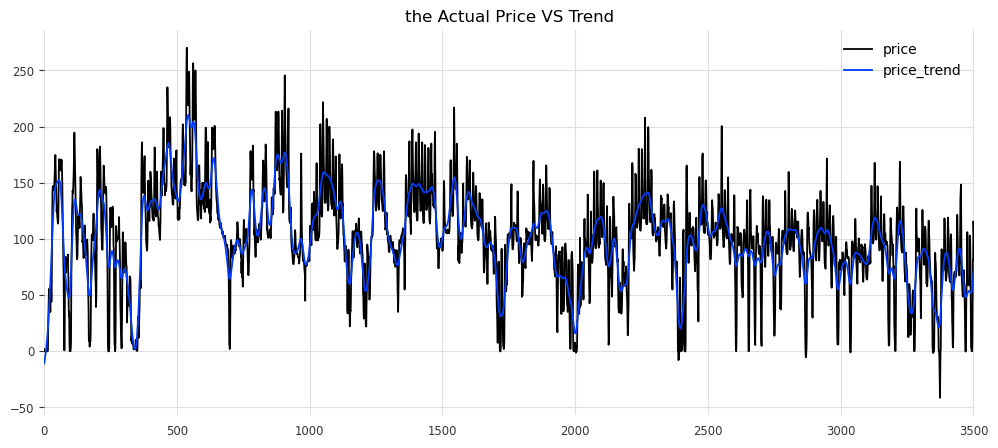

In [5]:
df_el[['price','price_trend']].plot(figsize=(12,5), title='the Actual Price VS Trend').autoscale(axis='x',tight=True)

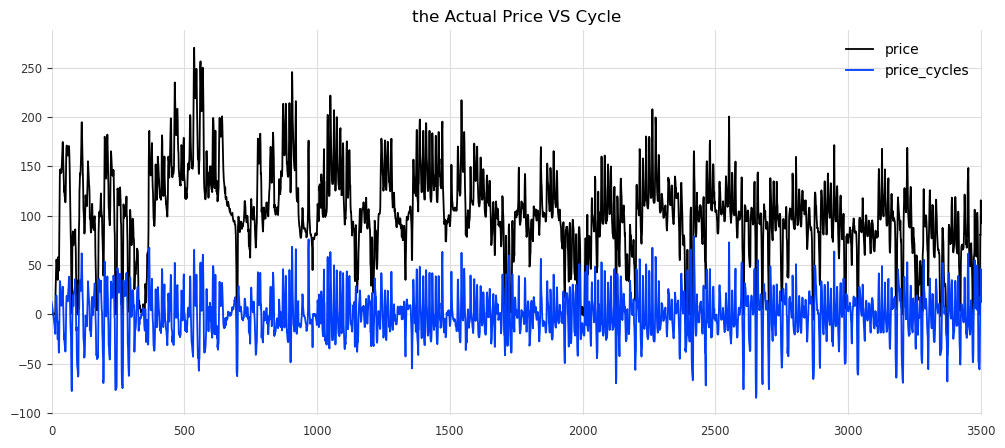

In [6]:
df_el[['price','price_cycles']].plot(figsize=(12,5),title='the Actual Price VS Cycle').autoscale(axis='x',tight=True)

In [7]:
# set the span and the smoothing factor alpha
span = 24
alpha = 2/(span+1)

In [8]:
# Set the frequency of the date time index as Monthly start as indicated by the data
df_el.set_index('date', inplace=True)

### Build simple, double, multi Exponential Smoothing

In [9]:
df_el['simple'] = ExponentialSmoothing(df_el['price']).fit(smoothing_level=alpha,optimized=False).fittedvalues

C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


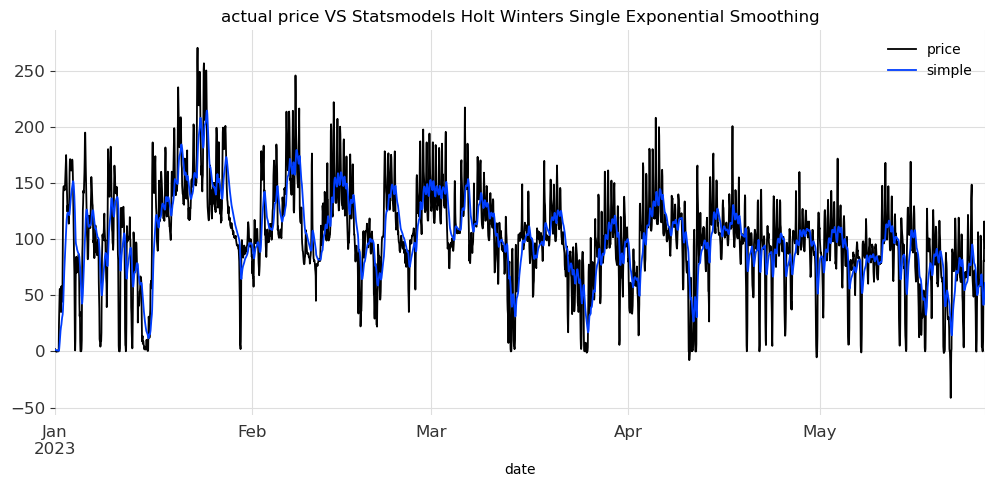

In [13]:
df_el[['price','simple']].plot(title='actual price VS Statsmodels Holt Winters Single Exponential Smoothing');

In [11]:
# double model
df_el['double'] = ExponentialSmoothing(df_el['price'],trend='add').fit().fittedvalues

C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


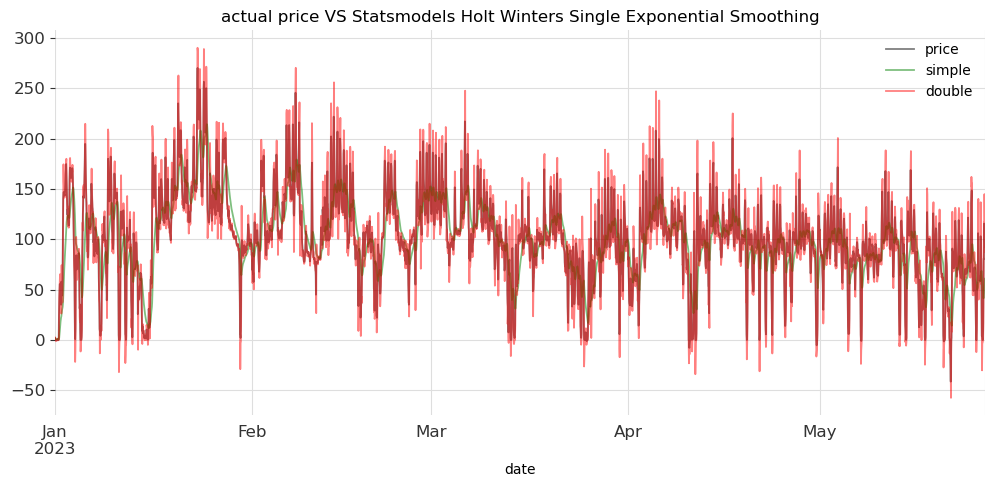

In [14]:
df_el[['price','simple','double']].plot(title='actual price VS Statsmodels Holt Winters Single Exponential Smoothing', color=['black', 'green', 'red'], alpha= 0.5);

In [15]:
df_el['multi'] = ExponentialSmoothing(df_el['price'], trend='add',seasonal='add',seasonal_periods=24).fit().fittedvalues

C:\Users\dicod\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


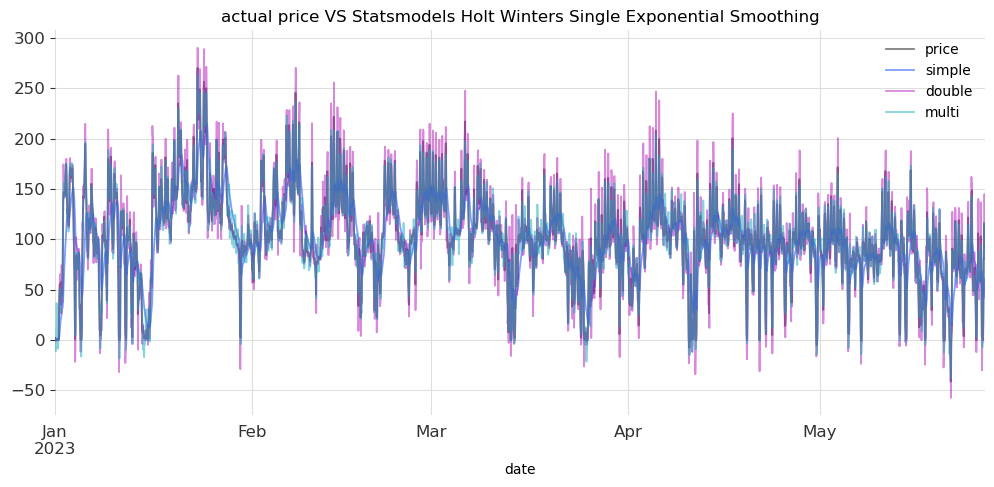

In [16]:
df_el[['price','simple','double','multi']].plot(title='actual price VS Statsmodels Holt Winters Single Exponential Smoothing', alpha= 0.5);

In [18]:
# compare the price by model_simple, double, multi
df_el.head(20)

,price,price_trend,price_cycles,simple,double,multi
date,,,,,,
2023-01-01 00:00:00,2.01,-10.834769,12.844769,1.302667,1.125273,-6.743143
2023-01-01 01:00:00,1.38,-9.209291,10.589291,1.359253,2.537246,-4.806246
2023-01-01 02:00:00,0.09,-7.575785,7.665785,1.360913,0.989982,-6.112388
2023-01-01 03:00:00,0.08,-5.919604,5.999604,1.259240,-1.022594,-11.069572
2023-01-01 04:00:00,0.05,-4.221312,4.271312,1.164901,-0.158934,-1.113502
2023-01-01 05:00:00,0.00,-2.457721,2.457721,1.075709,-0.017016,13.268288
2023-01-01 06:00:00,-0.38,-0.602975,0.222975,0.989652,-0.052419,36.573397
2023-01-01 07:00:00,0.00,1.370320,-1.370320,0.880080,-0.693235,28.930991
2023-01-01 08:00:00,0.00,3.489695,-3.489695,0.809673,0.237253,10.746926
